### 統計學習與深度學習
### Homework 5 (Kaggle Competition + IPYNB Report)

本次作業計畫讓大家練習影像分類的問題。每個人須將預測結果上傳至Kaggle，並將你方法執行的細節上傳至NTU COOL (IPYNB + HTML)。作業成績將會由Kaggle 排名 (70%)與繳交的IPYNB+HTML檔案內容 (30%)共同決定，分類預測結果需由繳交的code去產生，請誠實作答。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

影像分類是CNN模型的強項，我們的任務是區分照片中主角穿著類型，共區分成4種類別。這個問題在不同的情境下有不同的難度。在`Dive into Deep Learning`中有類似的問題，但是處理較"乾淨"的影像。這次作業的資料來自街拍影像，因此分類的困難度較高。

所有照片資料皆存放在`photos`資料夾當中。

`id_filename.txt`列出所有資料的id與檔名，並以逗號區隔。例如:
```
0,20190103082954015_500.jpg
1,20180727085751704_500.jpg
2,20180727145746586_500.jpg
```

`training_class.txt`中列出訓練資料的檔名與類別(類別以1~4代表)，並以逗號區隔。例如:
```
20170801213856270_500.jpg,2
20191103132929063_500.jpg,3
20191027153729784_500.jpg,1
```

未在訓練資料中的檔名，皆做為測試集(test set)。



## 任務

### Q1 (70%)
建構圖片分類模型。使用上述的訓練資料去訓練模型，預測所有測試集資料的類別。  
請輸出測試集的結果，上傳csv檔到Kaggle，只能有 id 跟 label 欄位，且須包含表頭，否則無法上傳成功，請參考以下範例：  
| id | label |
|----------|----------|
| 0    | 1   |
| 1    | 1   |
| 2    | 2   |  

每天有3次上傳檔案的機會，上傳後Kaggle會顯示accuracy之結果。 ***另外，請大家在Kaggle的team name設定為自己的學號。***  
  

提示:
* 你可以自行選用各種CNN Backbone。
* 可使用隨機水平翻轉(Horizontal Flip)、隨機旋轉(Random Rotation)等Data augmentation方式，改善分類表現。
* 可嘗試考慮SGD與ADAM等最佳化演算法，嘗試各種Learning Rate與其他Hyper-parameters。
* 請從training set中，自行分出10%~15%的資料作為validation set，調整模型參數以找出你的最佳模型。 


### Q2 (30%)
使用你表現最好的模型設定，畫出Training與Validation Loss，以及Training與Validation Accuracy，隨著Epoch變化的狀況。




In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
from PIL import Image

import optuna
from optuna import Trial

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import ParameterGrid
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
from tqdm import tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Read Data

In [32]:
# read training_class.txt
training_class = pd.read_csv('training_class.txt', sep=",", header=None)
training_class.columns = ["filename", "class"]    

# read id_filename.txt, first column is index, hece drop it
id_filename = pd.read_csv('id_filename.txt', sep=",", header=None)
id_filename.drop(id_filename.columns[[0]], axis=1, inplace=True)
id_filename.columns = ["filename"]

# create a dictionary to map filename to id
filename_id = {}
for i in range(len(id_filename)):
    filename_id[id_filename.iloc[i,0]] = i

id_predict = []

for file in id_filename["filename"].values:
    if file not in training_class["filename"].values:
        id_predict.append(file)

id_predict = pd.DataFrame(id_predict, columns=["filename"])

# CNN Model

我使用的是ResNet101這個CNN模型，並且有進行預訓練

In [29]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.base_model = resnet101(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Finding Best Hyperparameter

接著我使用Oputna，一個用於超參數優化的 Python 庫，去尋找最佳的hyperparameter。

我使用的是ADAM這個最佳化演算法。

其中有三個參數有很大的影響，分別為'learning rate', 'batch size', 'weightdecay'

因為大概5個batch就會收斂，所以每個trial我就給他跑5個batch去看他的表現。


In [14]:
def objective(trial):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

    # Create a dataset using ImageFolder
    train_dataset = datasets.ImageFolder(root='./data', transform=transform)

    # Create a DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    weight_Decay = trial.suggest_loguniform('weight_Decay', 1e-5, 1e-1)
    
    # Set the hyperparameters
    model = CustomCNN(num_classes=4)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_Decay)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    print(f"lr: {lr:.4e}, weight_decay: {weight_Decay:.4e}, batch_size: {batch_size}")
    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        acc = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            acc += (outputs.argmax(dim=1) == labels).float().mean()

    # Calculate the accuracy
    accuracy = acc / len(train_loader)
    print(f"Accuracy: {accuracy:.4f}")    
    # Return the accuracy as the objective value
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Get the best hyperparameters
best_params = study.best_params

# Print the best hyperparameters
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Best Hyperparameters:
# lr: 0.00017187084353515884
# batch_size: 32
# weight_Decay: 0.002535222000963198

[I 2023-12-27 23:03:56,313] A new study created in memory with name: no-name-8d41f5eb-7b24-473a-826f-412371cd25ff
/var/folders/l8/cns8rbyx5y17d2vn6gf6qkk80000gn/T/ipykernel_61506/1902943265.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/var/folders/l8/cns8rbyx5y17d2vn6gf6qkk80000gn/T/ipykernel_61506/1902943265.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_Decay = trial.suggest_loguniform('weight_Decay', 1e-5, 1e-1)
/Users/yl/Library/Caches/pypoetry/virtualenvs/html-qsiNAWFM-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 

lr: 1.7187e-04, weight_decay: 2.5352e-03, batch_size: 32


[I 2023-12-27 23:12:19,607] Trial 0 finished with value: 1.0 and parameters: {'lr': 0.00017187084353515884, 'batch_size': 32, 'weight_Decay': 0.002535222000963198}. Best is trial 0 with value: 1.0.


Accuracy: 1.0000
lr: 3.3623e-03, weight_decay: 1.7852e-03, batch_size: 64


[I 2023-12-27 23:20:37,246] Trial 1 finished with value: 0.7925326824188232 and parameters: {'lr': 0.0033622803703207776, 'batch_size': 64, 'weight_Decay': 0.0017851999559666712}. Best is trial 0 with value: 1.0.


Accuracy: 0.7925
lr: 2.8325e-03, weight_decay: 1.2006e-02, batch_size: 32


[I 2023-12-27 23:28:31,328] Trial 2 finished with value: 0.6333128213882446 and parameters: {'lr': 0.0028325265006353267, 'batch_size': 32, 'weight_Decay': 0.012005596626777441}. Best is trial 0 with value: 1.0.


Accuracy: 0.6333
lr: 3.1149e-03, weight_decay: 4.2969e-02, batch_size: 32


[I 2023-12-27 23:36:26,961] Trial 3 finished with value: 0.39562806487083435 and parameters: {'lr': 0.003114857195572061, 'batch_size': 32, 'weight_Decay': 0.042969293303970285}. Best is trial 0 with value: 1.0.


Accuracy: 0.3956
lr: 5.3083e-04, weight_decay: 1.9723e-04, batch_size: 32


[I 2023-12-27 23:44:47,087] Trial 4 finished with value: 0.9657738208770752 and parameters: {'lr': 0.0005308283622314886, 'batch_size': 32, 'weight_Decay': 0.00019723332789133352}. Best is trial 0 with value: 1.0.


Accuracy: 0.9658
Best Hyperparameters:
lr: 0.00017187084353515884
batch_size: 32
weight_Decay: 0.002535222000963198


# Train and eval with best hyperparameter

最後將資料集分為90% training, 10% evaluation，並且使用剛剛找到的最佳參數進行訓練。

然後我也有對於圖片進行一些預處理，首先是將圖片轉為tensor，接著講圖片resize成224,224可以去掉不重要的背景，最後進行normalize


In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='./data', transform=transform)
train_size = int(0.9 * len(train_dataset))
eval_size = len(train_dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(train_dataset, [train_size, eval_size])

batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

model = CustomCNN(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_Decay'])

num_epochs = 10

best_eval_loss = float('inf') 
training_loss = []
training_acc = []
evaluation_loss = [] 
evaluation_acc = [] 

for epoch in range(num_epochs):
    model.train()
    train_acc = 0
    train_loss = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Training)'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (outputs.argmax(dim=1) == labels).float().mean().item()

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)
    training_loss.append(avg_train_loss)
    training_acc.append(avg_train_acc)

    # Evaluation loop
    model.eval()
    eval_loss = 0
    eval_acc = 0

    with torch.no_grad():
        for inputs, labels in tqdm(eval_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Evaluation)'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            eval_acc += (outputs.argmax(dim=1) == labels).float().mean().item()

    # Calculate average evaluation loss and accuracy
    avg_eval_loss = eval_loss / len(eval_loader)  
    avg_eval_acc = eval_acc / len(eval_loader)  
    evaluation_loss.append(avg_eval_loss)  
    evaluation_acc.append(avg_eval_acc)  
    
    # Print and save results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, '
          f'Evaluation Loss: {avg_eval_loss:.4f}, Evaluation Accuracy: {avg_eval_acc:.4f}')


    # Save the model with the lowest evaluation loss
    if avg_eval_loss < best_eval_loss:
        best_eval_loss = avg_eval_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Save the trained model
torch.save(model.state_dict(), 'final_model.pth')

/Users/yl/Library/Caches/pypoetry/virtualenvs/html-qsiNAWFM-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yl/Library/Caches/pypoetry/virtualenvs/html-qsiNAWFM-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/yl/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:21<00:00, 11.4MB/s] 
Epoch 1/10 (Training):   0%|          | 0/38 [00:00<?, ?it/s]/Users/yl/L

Epoch [1/10], Training Loss: 0.5365, Training Accuracy: 0.8221, Evaluation Loss: 0.4872, Evaluation Accuracy: 0.8054


Epoch 2/10 (Evaluation): 100%|██████████| 5/5 [00:45<00:00,  9.04s/it]


Epoch [2/10], Training Loss: 0.1771, Training Accuracy: 0.9503, Evaluation Loss: 0.5774, Evaluation Accuracy: 0.8241


Epoch 3/10 (Evaluation): 100%|██████████| 5/5 [01:18<00:00, 15.68s/it]


Epoch [3/10], Training Loss: 0.0812, Training Accuracy: 0.9762, Evaluation Loss: 0.6738, Evaluation Accuracy: 0.8679


Epoch 4/10 (Evaluation): 100%|██████████| 5/5 [01:32<00:00, 18.46s/it]


Epoch [4/10], Training Loss: 0.1008, Training Accuracy: 0.9647, Evaluation Loss: 0.4877, Evaluation Accuracy: 0.8554


Epoch 5/10 (Evaluation): 100%|██████████| 5/5 [01:44<00:00, 20.99s/it]


Epoch [5/10], Training Loss: 0.0805, Training Accuracy: 0.9786, Evaluation Loss: 0.7865, Evaluation Accuracy: 0.8491


Epoch 6/10 (Evaluation): 100%|██████████| 5/5 [01:18<00:00, 15.76s/it]


Epoch [6/10], Training Loss: 0.0790, Training Accuracy: 0.9708, Evaluation Loss: 0.5982, Evaluation Accuracy: 0.8268


Epoch 7/10 (Evaluation): 100%|██████████| 5/5 [01:13<00:00, 14.62s/it]


Epoch [7/10], Training Loss: 0.0939, Training Accuracy: 0.9696, Evaluation Loss: 0.4244, Evaluation Accuracy: 0.8554


Epoch 8/10 (Evaluation): 100%|██████████| 5/5 [00:39<00:00,  7.94s/it]


Epoch [8/10], Training Loss: 0.0709, Training Accuracy: 0.9811, Evaluation Loss: 0.6461, Evaluation Accuracy: 0.8741


Epoch 9/10 (Evaluation): 100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


Epoch [9/10], Training Loss: 0.0798, Training Accuracy: 0.9741, Evaluation Loss: 0.7257, Evaluation Accuracy: 0.8054


Epoch 10/10 (Evaluation): 100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


Epoch [10/10], Training Loss: 0.1348, Training Accuracy: 0.9598, Evaluation Loss: 1.0262, Evaluation Accuracy: 0.7179


# Plot the curve for eval and train

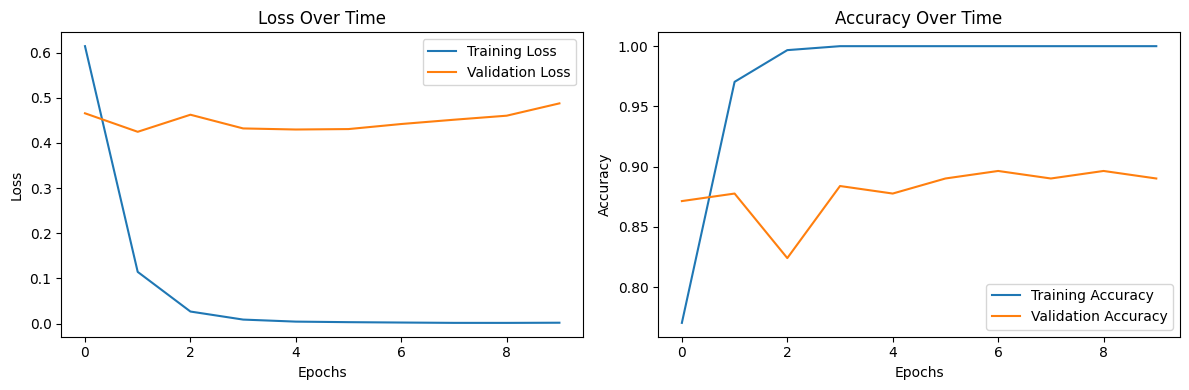

In [25]:
plt.figure(figsize=(12, 4))

# Subplot for the loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(evaluation_loss, label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for the accuracy
plt.subplot(1, 2, 2)
plt.plot(training_acc, label='Training Accuracy')
plt.plot(evaluation_acc, label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Output prediction

In [ ]:
# Load the trained model
model = CustomCNN(num_classes=4)
model.load_state_dict(torch.load('model.pth'))
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create a list of class names
class_names = ['1', '2', '3', '4']

# Open the CSV file and write headers
with open('predictions.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['id', 'label'])

    # Iterate through the test set
    for i in range(len(id_predict)):
        filename = id_predict.iloc[i]['filename']

        # Open the image and apply the transformations
        img = Image.open(os.path.join('./photos', filename))
        img = transform(img)
        img = img.unsqueeze(0)

        # Make predictions
        with torch.no_grad():
            preds = model(img)

        # Get the predicted class
        class_idx = torch.argmax(preds, dim=1).item()
        class_name = class_names[class_idx]

        # Write the prediction to the CSV file
        csvwriter.writerow([filename_id[filename], class_name])
